# NCAR EDA

## Intro
The purpose of this notebook is to perform exploratory data analysis (EDA) for the NCAR Alaska Near Surface Meteorology Daily Averages and the Alaska VIC Hydro Model Output (1950-2099) Daily Averages [dataset](https://www.earthsystemgrid.org/dataset/ucar.ral.hydro.predictions.html). These data are available for download from the Climate Data Gateway at NCAR. A preliminary version of these data were made available to SNAP prior to their hosting at NCAR - it was found in processing that this preliminary dataset was missing data for a few instances. This discovery prompted the EDA work here, using the NCAR hosted dataset as the source.


## Background
Adapted from the NCAR Climate Data Gateway summary:

High resolution ensembles of hydroclimate projections are useful for climate and water resources adaptation planning. Very few century-long, high-resolution hydroclimate projections exist over Alaska and none are statewide. This motivated developmean of a dataset consisting of multiple statistically downscaled climate model projections and corresponding off-line hydrologic model simulations to obtain hydrologic simulations from 1950 to 2099 over Alaska, which fills a critical gap in hydroclimate projection capabilities. Robust warming and increases in precipitation produce runoff increases for most of Alaska. However, runoff is likely to decrease in current glacierized areas in southeast Alaska.

Approach:
1) select climate model outputs based on CMIP5 RCPs 4.5 and 8.5
2) perform statistical downscaling to generate high-resolution climate input data for hydrologic models (12-km grid-spacing for Alaska
3) perform off-line hydrologic model simulations, using the Variable Infiltration Capacity (VIC) model. A full water-energy balance computation with a simple glacier model for Alaska is used.

## Incoming Data Structure
The source data are annual netCDF files (with a daily frequency time step) that contain the data for a single model and scenario. There are 10 models and 2 scenarios. Within each model-scenario combination (can we just call these a "climate future" or something?) there are files of a few different types.

The Alaska Near Surface Meteorology Daily Averages have files names like `ACCESS1-3_rcp45_BCSD_met_1958.nc` and the `met` tag indicates that these files contain the following climate variables:

 - tmax (Maximum Daily 2-m air temperature, degrees C)
 - tmin (Minimum Daily 2-m air temperature, degrees C)
 - pcp (Daily precipitation, mm per day)
 
These variables are downscaled climate model output - they are not created by the VIC hydrologic model. The VIC outputs have filenames like `MRI-CGCM3_rcp85_BCSD_ws_2094.nc`, `GFDL-ESM2M_rcp85_BCSD_wf_2035.nc` and `CSIRO-Mk3-6-0_rcp85_BCSD_eb_2044.nc` where the tags `wf`, `ws` and `eb` are a shorthand that indicate what types of variables exist within thos file sets. The scheme is as follows:

 - `ws` (water source / state)
   - SWE (Snow water equivalent, mm)
   - IWE (Ice water equivalent, mm)
   - SM1 (Soil moisture layer1, mm)
   - SM2 (Soil moisture layer1, mm)
   - SM3 (Soil moisture layer3, mm)
   - WATER_ERROR (water balance error, mm)
   
 - `wf` (water flow / rate)
   - RUNOFF (surface runoff, mm per day)
   - BASEFLOW (baseflow, mm per day)
   - EVAP (actual evapotranspiration, mm per day)
   - PRCP (precipitation, mm per day)
   - SNOW_MELT (snow melt, mm per day)
   - GLACER_MELT (ice melt, mm per day)
   
 - `eb` (energy balance)
   - NET_SHORT (net shortwave radiation, W/m<sup>2</sup>)
   - NET_LONG (net longwave radiation, W/m<sup>2</sup>)
   - SENSIBLE (sensible heat flux, W/m<sup>2</sup>)
   - LATENT (latent heat flux, W/m<sup>2</sup>)
   - GRND_FLUX (ground heat flux, W/m<sup>2</sup>)
   - SOIL_TEMP1 (soil temperature layer 1, degrees C)
   - SOIL_TEMP2 (soil temperature layer 2, degrees C)
   - SOIL_TEMP3 (soil temperature layer 3, degrees C)
   - ENERGY_ERROR (energy balance error, W/m<sup>2</sup>)
   
 
Note that our initial scope of work for this dataset does not include the energy balance (`eb`) portion of the VIC model outputs.


## EDA Goals

 - Mirror the NCAR dataset as it exists online at the NCAR Climate Data Gateway. 
 - Assert the expected number of files are present for each model scenario combination.
 - Check for a consistent set of attributes for each set of files.
 - Within each file set, assert that the expected data variables are present.
 - Within each file set assert that the nodata, miniumum, and maximum values are consistent and in an expected range for that variable.
 - Visualize a selection of each variable.

## Data Fetch
The NCAR Climate Data Gateway provides a few mechanisms to download the necessary data. The best for our purposes are these auto-generated shell scripts:

`wget-ucar.ral.hydro.predictions.alaska.met.daily-20230228T0933Z.sh`

`wget-ucar.ral.hydro.predictions.alaska.vic.daily-20230224T1218Z.sh`

To download the source data just execute these scripts from a working directory where you'd like to download the data to. I've download the full set of data to `/atlas_scratch/cparr4/ncar_replacement_data` - the "replacment" indicates that these data are distinct from the preliminary data we have already have on disk. The total download size is about 855 GB and might about a day to download data to Atlas.

These scripts may download the `daymet` data also - we should set these aside for now as they only run 1980-2016, and the version of them we have already on disk have been thoroughly used in the Spruce Beetle work. We can stash them somewhere (`mv daymet* ../scratch/daymet`) and come back to them later as needed.

In [1]:
import os
from pathlib import Path

DATA_DIR = Path(os.getenv("NCAR_DATA_DIR") or "/atlas_scratch/cparr4/ncar_replacement_data")
DATA_DIR.mkdir(exist_ok=True, parents=True)

## Count the Files

There are ten (10) models, two scenarios (2), four (4) file sets (the met data plus the three flavors of VIC output) and 1950-2099 (150) years worth of output. We should therefore have 10 * 2 * 4 * 150 total files.

In [2]:
total_files = 10 * 2 * 4 * 150
total_files

12000

In [3]:
from config import models, scenarios, years, variable_groupings, variable_di

In [4]:
paths = list(DATA_DIR.glob('*.nc'))
assert len(paths) == total_files

In [5]:
model_di = {}
for model in models:
    model_di[model] = []
    
scenario_di = {}
for scenario in scenarios:
    scenario_di[scenario] = []

year_di = {}
for year in years:
    year_di[year] = []

var_group_di = {}
for var_group in variable_groupings:
    var_group_di[var_group] = []

for nc_file in paths:
    
    file_model = nc_file.name.split("_")[0]
    file_scenario = nc_file.name.split("_")[1]
    file_year = nc_file.name.split("_")[-1].split(".")[0]
    file_var_group = nc_file.name.split("_")[-2]
    
    model_di[file_model].append(nc_file)
    scenario_di[file_scenario].append(nc_file)
    year_di[int(file_year)].append(nc_file)
    var_group_di[file_var_group].append(nc_file)

In [6]:
assert set([len(model_di[x]) for x in model_di.keys()]) == set([1200])

assert set([len(scenario_di[x]) for x in scenario_di.keys()]) == set([6000])

assert set([len(year_di[x]) for x in year_di.keys()]) == set([80])

assert set([len(var_group_di[x]) for x in var_group_di.keys()]) == set([3000])

OK so we've established that the number of files downloaded is as expected, at that those file are evenly distributed amongst the various models, scenarios, years, and variable groupings. That's good. Next we'll check the global attributes of these netCDF files. Based on what we know about the dataset so far, the files vary the most across the "variable groupings" axis - so we'll chunk this up that way.

In [15]:
import xarray as xr
from tqdm import tqdm
import numpy as np

normal_dim = [209, 299, 365]
leap_dim = [209, 299, 366]

with xr.open_dataset(DATA_DIR / "CCSM4_rcp85_BCSD_met_2005.nc") as ds:
    met_ref_coords = ds.coords
    
unruly_files = []

for var_group in variable_groupings:
    # omit the energy balance variables - out of scope
    if var_group != "eb":
        ds_dims = []
        ds_indices = []
        ds_coords = []
        for nc_file in tqdm(var_group_di[var_group], desc=f"Scanning {var_group} variable group"):
            with xr.open_dataset(nc_file) as ds:

                # check data three dimensional (time)
                dims = list(ds.dims.values())
                if sorted(dims) == normal_dim or sorted(dims) == leap_dim:
                    pass
                else:
                    print(f"{nc_file.name} has unusual dimensions of {dims}")
                    unruly_files.append(nc_file)

                # check daily frequency including leap years
                if ds.coords["time"].shape[0] == 365 or ds.coords["time"].shape[0] == 366:
                    pass
                else:
                    print(f"{nc_file.name} has unusual coordinates of {ds.coords}")
                    unruly_files.append(nc_file)

                ds_indices.append(ds.indexes)

                # check expected variables exist in each file as a DataArray
                data_vars = set(list(ds.data_vars.keys()))
                ref_vars = set(list(variable_di[var_group].keys()))
                test_vars = set.intersection(data_vars, ref_vars)
                if test_vars == ref_vars:
                    pass
                else:
                    print(f"{nc_file.name} only has the following data variables: {data_vars}")
                    
        if len(np.unique(ds_indices)) == 1:
            print("All files have the same indices.")
        else:
            print("Some files have different indices.")
            print(np.unique(ds_indices))

Scanning met variable group:  52%|█████▏    | 1560/3000 [01:09<01:07, 21.41it/s]

HadGEM2-ES_rcp45_BCSD_met_2005.nc has unusual dimensions of [334, 209, 299]
HadGEM2-ES_rcp45_BCSD_met_2005.nc has unusual coordinates of Coordinates:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-11-30


Scanning met variable group:  57%|█████▋    | 1709/3000 [01:15<01:02, 20.80it/s]

HadGEM2-ES_rcp85_BCSD_met_2005.nc has unusual dimensions of [334, 209, 299]
HadGEM2-ES_rcp85_BCSD_met_2005.nc has unusual coordinates of Coordinates:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-11-30


Scanning met variable group: 100%|██████████| 3000/3000 [02:04<00:00, 24.01it/s]


All files have the same indices.


Scanning wf variable group: 100%|███████████| 3000/3000 [02:42<00:00, 18.44it/s]


All files have the same indices.


Scanning ws variable group: 100%|███████████| 3000/3000 [04:32<00:00, 11.03it/s]

All files have the same indices.


In [16]:
np.unique(unruly_files)

array([PosixPath('/atlas_scratch/cparr4/ncar_replacement_data/HadGEM2-ES_rcp45_BCSD_met_2005.nc'),
       PosixPath('/atlas_scratch/cparr4/ncar_replacement_data/HadGEM2-ES_rcp85_BCSD_met_2005.nc')],
      dtype=object)

So two files don't have a full year's worth of data - they seem to be missing data for the month of December. These files are `HadGEM2-ES_rcp45_BCSD_met_2005.nc` and `HadGEM2-ES_rcp85_BCSD_met_2005.nc`. We'll want to contact NCAR about this eventually. For the short term we might set aside this particular model (HadGEM2-ES) when processing. Aside from these two files the data seem homogeneous enough - the files have the expected variables and are structured with the same 209 X 299 spatial grid and with a daily time-step, including leap years. The next step is to start sampling for value ranges and nodata values.

In [19]:
import dask
import dask.array as da
from dask.distributed import Client
from dask import delayed
from tqdm.notebook import tqdm_notebook

# define a delayed function to compute stats for all variables for a single file
@delayed
def compute_stats_for_file(file, ref_vars):
    with xr.open_dataset(file) as ds:
        file_stats = {}
        for variable in ref_vars:
            da = ds[variable].chunk()  # chunk the data for parallel processing
            file_stats[variable] = {"filename": file.name,
                                    "min_vals": float(da.min()),
                                    "mean_vals": float(da.mean()),
                                    "max_vals": float(da.max()),
                                    "nan_count": float(da.isnull().sum()),
                                    "arr_size": float(da.size)}
        return file_stats

# create dask client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45516,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.72 GiB
Comm: tcp://127.0.0.1:36290,Total threads: 4
Dashboard: http://127.0.0.1:45416/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:43962,


In [20]:
import pandas as pd

summary_stat_di = {}

for var_group in variable_groupings:
    print(var_group)
    # omit the energy balance variables - out of scope
    if var_group != "eb":
        ref_vars = list(variable_di[var_group].keys())
        
        all_file_stats = []

        for nc_file in tqdm_notebook(var_group_di[var_group], desc=f"Sampling values from the {var_group} variable group"):
            all_file_stats.append(compute_stats_for_file(nc_file, ref_vars))
        stat_result = dask.compute(*all_file_stats)
        init_df = pd.DataFrame.from_dict(stat_result).T
        
        # each column of the df contains a dict of summary statistics from one file
        # each row of the df corresponds to a variable
        # transform this such that each dict key is a column, and each row is a file
        
        output_dfs = []

        for idx in init_df.index:
            row_dict = init_df.loc[idx].to_dict()
            df = pd.DataFrame(row_dict).T
            df["variable"] = idx
            output_dfs.append(df)
        summary_stat_di[var_group] = pd.concat(output_dfs)
        

met


Sampling values from the met variable group:   0%|          | 0/3000 [00:00<?, ?it/s]

wf


Sampling values from the wf variable group:   0%|          | 0/3000 [00:00<?, ?it/s]

ws


Sampling values from the ws variable group:   0%|          | 0/3000 [00:00<?, ?it/s]

eb


In [21]:
summary_stat_di

{'met':                               filename   min_vals mean_vals    max_vals  \
 0     ACCESS1-3_rcp45_BCSD_met_1950.nc        0.0  2.115409  334.122833   
 1     ACCESS1-3_rcp45_BCSD_met_1951.nc        0.0  1.781025  373.400421   
 2     ACCESS1-3_rcp45_BCSD_met_1952.nc        0.0   2.30628  292.724426   
 3     ACCESS1-3_rcp45_BCSD_met_1953.nc        0.0  2.491148  483.730438   
 4     ACCESS1-3_rcp45_BCSD_met_1954.nc        0.0  2.117231  201.814102   
 ...                                ...        ...       ...         ...   
 2995  MRI-CGCM3_rcp85_BCSD_met_2095.nc -55.630352 -3.283204   21.445778   
 2996  MRI-CGCM3_rcp85_BCSD_met_2096.nc -55.804386 -3.562839   22.493387   
 2997  MRI-CGCM3_rcp85_BCSD_met_2097.nc -51.919365 -2.530221   24.924873   
 2998  MRI-CGCM3_rcp85_BCSD_met_2098.nc  -51.14386 -2.654892   22.903215   
 2999  MRI-CGCM3_rcp85_BCSD_met_2099.nc -51.596119 -1.735741   25.028862   
 
        nan_count    arr_size variable  
 0     17607965.0  22809215.0      pcp

In [22]:
import pickle
with open('eda_summary_stats.pickle', 'wb') as handle:
    pickle.dump(summary_stat_di, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
import pickle
with open('eda_summary_stats.pickle', 'rb') as handle:
    summary_stat_di = pickle.load(handle)

Let's check the results for the `met` variables of:


 - tmax (Maximum Daily 2-m air temperature, °C)
 - tmin (Minimum Daily 2-m air temperature, °C)
 - pcp (Daily precipitation, mm per day)

We'd expect `pcp` to have a minimum bound at zero - there should not be any negative precipitation amounts.
We'd expect temperatures to range between around -70°F and 110°F, or about -57°C and 44°C. 

Recall that for each variable and for each file (one file per year, daily frequency data) we extracted min, mean, and max values. We'll summarize each of those values again by min, mean, and max to see some values for each variable.

In [33]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").min().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,1.3,121.4,16112494.0,20871994.0
tmax,-70.9,-3.5,28.0,16112494.0,20871994.0
tmin,-70.6,-12.6,14.1,16112494.0,20871994.0


The minimums of the min-mean-max-value extractions looks OK. The `pcp` min is zero as expected, although we can see there are some very extreme temps here - the coldest `tmax` and `tmin` temps in this entire dataset are about -71°C, which is about -96°F! However, that could be realistic for January on top of Denali or something like that. It is unexpected that the coldest `tmax` is actually colder than the coldest `tmin` - but it is close enough that might just a floating noise artifact. Good to see a stable minimum `nan_count` - put another way, the maximum data extent for each of these variables is indentical.

In [34]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").mean().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,2.3,377.3,17618867.5,22823338.0
tmax,-55.2,2.8,35.5,17618867.5,22823338.0
tmin,-56.8,-6.2,20.7,17618867.5,22823338.0


The means of the min-mean-max-value extractions also looks OK as well. The deltas between `tmin` and `tmax` seem right: `tmax` is warmer for all cases. Consider the average maximum `pcp` value of 377 mm, or 37 cm. That's about 14.5 inches of rain!! Which seems like a crazy amount of water, but again we need to know more about how to interpret that number over a 12 km X 12 km rainfall. And the Alaska 24-hr rainfall record is about 15 inches (likely Seward 10 October 1986).

In [35]:
summary_stat_di["met"].drop(["filename"], axis=1).groupby("variable").max().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
pcp,0.0,3.7,1591.4,17656206.0,22871706.0
tmax,-42.8,13.5,50.8,17656206.0,22871706.0
tmin,-43.7,4.4,38.7,17656206.0,22871706.0


The maximums of the min-mean-max-value summaries are interesting. The largest `pcp` valye in the dataset is equivalent to about 62 inches of rain. That's just shy of the [world record](https://www.weather.gov/owp/hdsc_world_record) for 24-hour rainfall. The hottest temps in the dataset are scary (50°C or 122°F).

In [36]:
import numpy as np
np.unique(summary_stat_di["met"]["nan_count"], return_counts=True)

(array([16112494.0, 17607965.0, 17656206.0], dtype=object),
 array([   6, 6774, 2220]))

In [37]:
np.unique(summary_stat_di["met"]["arr_size"], return_counts=True)

(array([20871994.0, 22809215.0, 22871706.0], dtype=object),
 array([   6, 6774, 2220]))

In [38]:
summary_stat_di["met"][summary_stat_di["met"]["nan_count"] == 16112494.0]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,0.0,2.362475,512.656616,16112494.0,20871994.0,pcp
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,0.0,1.958856,926.602661,16112494.0,20871994.0,pcp
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,-59.359783,3.793049,36.030167,16112494.0,20871994.0,tmax
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,-59.496304,3.144587,35.335285,16112494.0,20871994.0,tmax
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,-60.977978,-7.021136,19.551376,16112494.0,20871994.0,tmin
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,-60.977978,-7.139573,18.91655,16112494.0,20871994.0,tmin


In [39]:
summary_stat_di["met"][summary_stat_di["met"]["arr_size"] == 20871994]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,0.0,2.362475,512.656616,16112494.0,20871994.0,pcp
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,0.0,1.958856,926.602661,16112494.0,20871994.0,pcp
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,-59.359783,3.793049,36.030167,16112494.0,20871994.0,tmax
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,-59.496304,3.144587,35.335285,16112494.0,20871994.0,tmax
1555,HadGEM2-ES_rcp45_BCSD_met_2005.nc,-60.977978,-7.021136,19.551376,16112494.0,20871994.0,tmin
1705,HadGEM2-ES_rcp85_BCSD_met_2005.nc,-60.977978,-7.139573,18.91655,16112494.0,20871994.0,tmin


Ok so the six data arrays that have far fewer "nodata" values and smaller array sizes than the rest of the dataset are the same two offending files that seemed to be missing data for December: `HadGEM2-ES_rcp45_BCSD_met_2005.nc` and `HadGEM2-ES_rcp85_BCSD_met_2005.nc`

Next we'll check the results for the `wf` variables of:


 - RUNOFF (surface runoff, mm per day)
 - EVAP (actual evapotranspiration, mm per day)
 - SNOW_MELT (snow melt, mm per day)
 - GLACER_MELT (ice melt, mm per day)


We'd expect all of these variables to have minimum bounds at zero - there should not be any negative water amounts...that wouldn't really make sense. Only exceptions might be if these variables mean something else in a modeling context. `RUNOFF` and `SNOW_MELT` value ranges should be similar to precip value ranges we looked at earlier, and we can infer from this [WRCC source](https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg) that summertime `EVAP` rates might be in the 0 to 10 mm per day range. Recall that for each variable and for each file (one file per year, daily frequency data) we extracted min, mean, and max values. We'll summarize each of those values again by min, mean, and max to see some values for each variable.

In [43]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").min().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-3.0,0.4,5.7,17616360.0,22809215.0
GLACIER_MELT,-inf,-inf,2105.0,17616360.0,22809215.0
RUNOFF,0.0,0.7,514.9,17616360.0,22809215.0
SNOW_MELT,-0.0,0.8,525.9,17616360.0,22809215.0


Well the smallest value in the entire dataset for `EVAP` and `SNOW_MELT` are slightly negative - but this looks like model noise to me so I'm not too concerned. `GLACIER_MELT` is odd, I didn't expect to see `-inf` pop up here, this may indicate a "not modeled" (vs. nodata) grid cell state. 

In [44]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").mean().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-1.3,0.6,7.1,17628265.1,22824629.4
GLACIER_MELT,-inf,-inf,4025.7,17628265.1,22824629.4
RUNOFF,0.0,1.2,946.8,17628265.1,22824629.4
SNOW_MELT,-0.0,1.5,999.5,17628265.1,22824629.4


The average of minimum `EVAP` values is -1.3, which seems signficant given the average of the mean `EVAL` values is only 0.6. This makes me think that the negative EVAP values mean something - and aren't just float noise.

In [42]:
summary_stat_di["wf"].drop(["filename"], axis=1).groupby("variable").max().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
EVAP,-0.7,0.8,9.3,17664624.0,22871706.0
GLACIER_MELT,0.0,62.9,9571.2,17664624.0,22871706.0
RUNOFF,0.0,2.4,1722.7,17664624.0,22871706.0
SNOW_MELT,0.0,3.1,1847.3,17664624.0,22871706.0


These values look good - intense glacial melt though! That's about 370 inches of water in **one day**.

In [47]:
np.unique(summary_stat_di["wf"]["nan_count"], return_counts=True)

(array([17616360.0, 17664624.0], dtype=object), array([9040, 2960]))

In [48]:
np.unique(summary_stat_di["wf"]["arr_size"], return_counts=True)

(array([22809215.0, 22871706.0], dtype=object), array([9040, 2960]))

In [49]:
summary_stat_di["wf"][summary_stat_di["wf"]["arr_size"] == 22871706]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
2,ACCESS1-3_rcp45_BCSD_wf_1952.nc,-0.001,2.480878,1130.030029,17664624.0,22871706.0,SNOW_MELT
6,ACCESS1-3_rcp45_BCSD_wf_1956.nc,-0.002,2.382929,1087.991943,17664624.0,22871706.0,SNOW_MELT
10,ACCESS1-3_rcp45_BCSD_wf_1960.nc,-0.002,2.308526,1046.667969,17664624.0,22871706.0,SNOW_MELT
14,ACCESS1-3_rcp45_BCSD_wf_1964.nc,0.0,1.774698,1019.007019,17664624.0,22871706.0,SNOW_MELT
18,ACCESS1-3_rcp45_BCSD_wf_1968.nc,-0.002,1.7265,1024.254028,17664624.0,22871706.0,SNOW_MELT
...,...,...,...,...,...,...,...
2980,MRI-CGCM3_rcp85_BCSD_wf_2080.nc,0.0,1.230368,980.958008,17664624.0,22871706.0,RUNOFF
2984,MRI-CGCM3_rcp85_BCSD_wf_2084.nc,0.0,1.024941,667.612976,17664624.0,22871706.0,RUNOFF
2988,MRI-CGCM3_rcp85_BCSD_wf_2088.nc,0.0,1.247963,893.039978,17664624.0,22871706.0,RUNOFF
2992,MRI-CGCM3_rcp85_BCSD_wf_2092.nc,0.0,1.058361,800.357971,17664624.0,22871706.0,RUNOFF


I was starting to worry about the array size and nan counts were split 9040 / 2960 - but these are just leap years!

Finally let's check the results for the `ws` variables of:

 - SWE (Snow water equivalent, mm)
 - IWE (Ice water equivalent, mm)
 - SM1 (Soil moisture layer1, mm)
 - SM2 (Soil moisture layer1, mm)
 - SM3 (Soil moisture layer3, mm)
 
My understanding is that these variables all indicate the amount of water present in a grid cell at a given time step. My expectation is that we will not see any negative values here, because a negative amount of water wouldn't make sense. Otherwise I'm not too sure what to expect. These are all in units of millimeters, so a value of 500,000 indicates 500 m of water..which seems like a ton and perhaps way too much - unless that is then distributed over a 12 km X 12 km grid cell. I'm not sure how all that works. 

In [50]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").min().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,666.4,225118.3,17616360.0,22809215.0
SM1,0.0,7.3,12.9,17616360.0,22809215.0
SM2,70.8,310.7,587.2,17616360.0,22809215.0
SM3,0.0,9.3,156.8,17616360.0,22809215.0
SWE,0.0,92.9,501480.4,17616360.0,22809215.0


In [51]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").mean().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,5740.9,447031.1,17628265.1,22824629.4
SM1,0.0,8.1,13.0,17628265.1,22824629.4
SM2,84.0,345.1,619.7,17628265.1,22824629.4
SM3,0.0,18.7,167.9,17628265.1,22824629.4
SWE,0.0,180.8,620792.5,17628265.1,22824629.4


In [52]:
summary_stat_di["ws"].drop(["filename"], axis=1).groupby("variable").max().round(1)

,min_vals,mean_vals,max_vals,nan_count,arr_size
variable,,,,,
IWE,0.0,17037.6,839723.7,17664624.0,22871706.0
SM1,0.0,8.8,13.0,17664624.0,22871706.0
SM2,121.0,377.4,644.8,17664624.0,22871706.0
SM3,0.0,38.4,177.9,17664624.0,22871706.0
SWE,0.0,277.8,687468.4,17664624.0,22871706.0


`SM2` never goes dry? Is that because there is always some water storage there? But then why is `SM3` dry in some cases - maybe there are soil or rock coverages where water never penetrates that deep. That'd make sense for less penetrable cases like exposed bedrock or something.

In [53]:
np.unique(summary_stat_di["ws"]["nan_count"], return_counts=True)

(array([17616360.0, 17664624.0], dtype=object), array([11300,  3700]))

In [54]:
np.unique(summary_stat_di["ws"]["arr_size"], return_counts=True)

(array([22809215.0, 22871706.0], dtype=object), array([11300,  3700]))

In [63]:
# check for leap years again
summary_stat_di["wf"][summary_stat_di["wf"]["arr_size"] == 22871706]

,filename,min_vals,mean_vals,max_vals,nan_count,arr_size,variable
2,ACCESS1-3_rcp45_BCSD_wf_1952.nc,-0.001,2.480878,1130.030029,17664624.0,22871706.0,SNOW_MELT
6,ACCESS1-3_rcp45_BCSD_wf_1956.nc,-0.002,2.382929,1087.991943,17664624.0,22871706.0,SNOW_MELT
10,ACCESS1-3_rcp45_BCSD_wf_1960.nc,-0.002,2.308526,1046.667969,17664624.0,22871706.0,SNOW_MELT
14,ACCESS1-3_rcp45_BCSD_wf_1964.nc,0.0,1.774698,1019.007019,17664624.0,22871706.0,SNOW_MELT
18,ACCESS1-3_rcp45_BCSD_wf_1968.nc,-0.002,1.7265,1024.254028,17664624.0,22871706.0,SNOW_MELT
...,...,...,...,...,...,...,...
2980,MRI-CGCM3_rcp85_BCSD_wf_2080.nc,0.0,1.230368,980.958008,17664624.0,22871706.0,RUNOFF
2984,MRI-CGCM3_rcp85_BCSD_wf_2084.nc,0.0,1.024941,667.612976,17664624.0,22871706.0,RUNOFF
2988,MRI-CGCM3_rcp85_BCSD_wf_2088.nc,0.0,1.247963,893.039978,17664624.0,22871706.0,RUNOFF
2992,MRI-CGCM3_rcp85_BCSD_wf_2092.nc,0.0,1.058361,800.357971,17664624.0,22871706.0,RUNOFF


In [121]:
met_pcp_df = summary_stat_di["met"].set_index("filename").query("variable == 'pcp'")
met_tmin_df = summary_stat_di["met"].set_index("filename").query("variable == 'tmin'")
met_tmax_df = summary_stat_di["met"].set_index("filename").query("variable == 'tmax'")

In [155]:
import matplotlib.pyplot as plt
max_pcp = met_pcp_df.sort_values("max_vals").index[-1]
min_tmin = met_tmin_df.sort_values("max_vals").index[0]
max_tmax = met_tmax_df.sort_values("max_vals").index[-1]

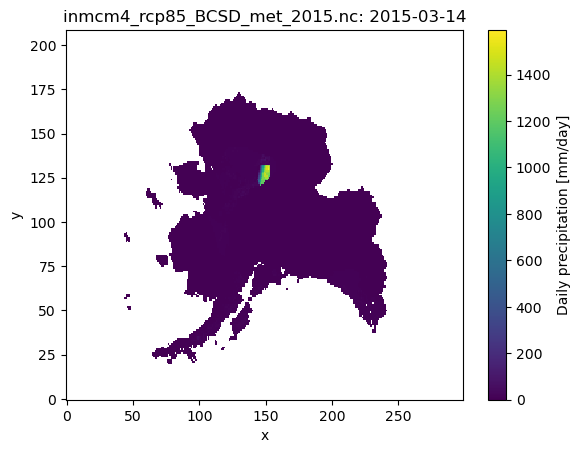

In [184]:
with xr.open_dataset(DATA_DIR / max_pcp) as ds:
    
    da = ds.pcp
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_pcp}: {tstr}")

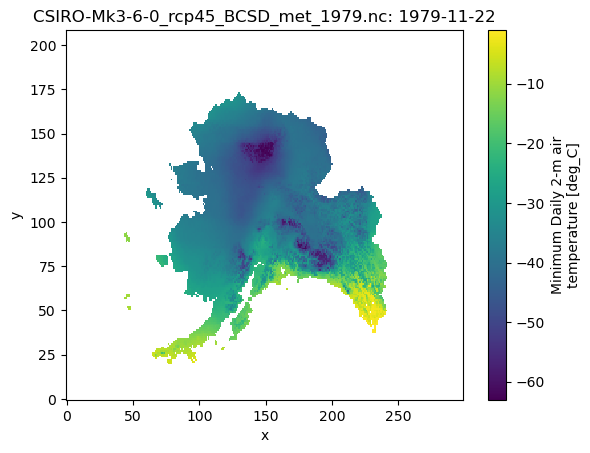

In [183]:
with xr.open_dataset(DATA_DIR / min_tmin) as ds:
    
    da = ds.tmin
    min_val = da.min()
    min_loc = da.argmin()

    min_loc_tuple = np.unravel_index(min_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[min_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{min_tmin}: {tstr}")

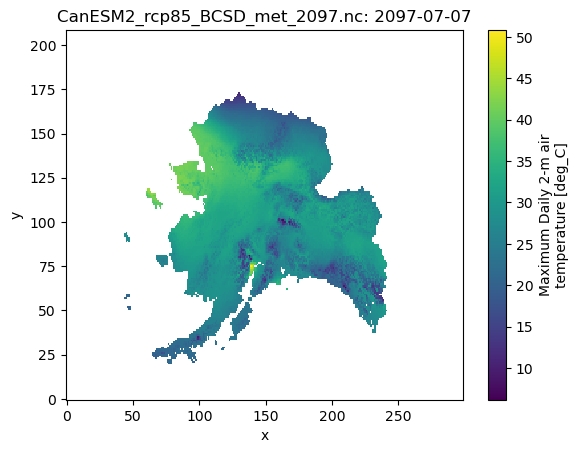

In [182]:
with xr.open_dataset(DATA_DIR / max_tmax) as ds:
    
    da = ds.tmax
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]
    da.sel(time=time_slice).plot()
    plt.title(f"{max_tmax}: {tstr}")

In [185]:
ws_swe_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SWE'")
ws_iwe_df = summary_stat_di["ws"].set_index("filename").query("variable == 'IWE'")
ws_sm1_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM1'")
ws_sm2_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM2'")
ws_sm3_df = summary_stat_di["ws"].set_index("filename").query("variable == 'SM3'")

In [186]:
max_swe = ws_swe_df.sort_values("max_vals").index[-1]
max_iwe = ws_iwe_df.sort_values("max_vals").index[-1]
max_sm1 = ws_sm1_df.sort_values("max_vals").index[-1]
max_sm2 = ws_sm2_df.sort_values("max_vals").index[-1]
max_sm3 = ws_sm3_df.sort_values("max_vals").index[-1]

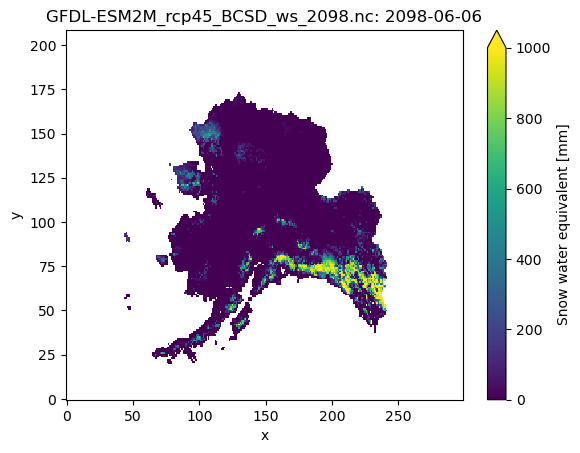

In [191]:
with xr.open_dataset(DATA_DIR / max_swe) as ds:
    
    da = ds.SWE
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=1000)
    plt.title(f"{max_swe}: {tstr}")

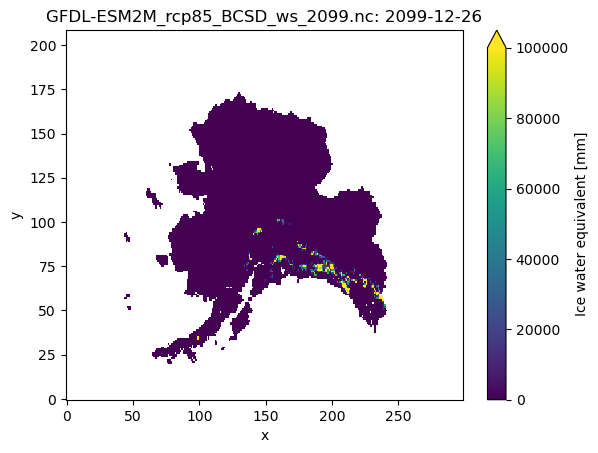

In [195]:
with xr.open_dataset(DATA_DIR / max_iwe) as ds:
    
    da = ds.IWE
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100000)
    plt.title(f"{max_iwe}: {tstr}")

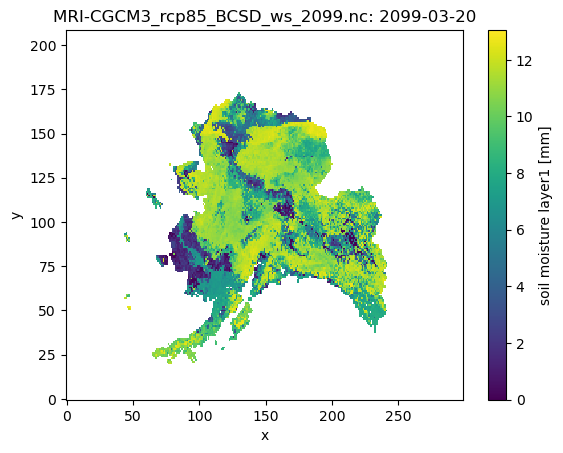

In [196]:
with xr.open_dataset(DATA_DIR / max_sm1) as ds:
    
    da = ds.SM1
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm1}: {tstr}")

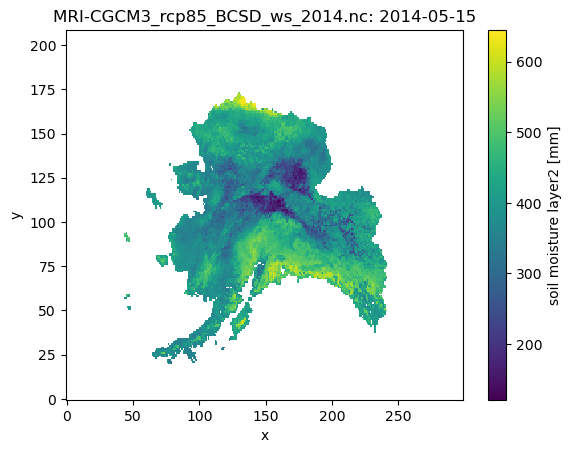

In [197]:
with xr.open_dataset(DATA_DIR / max_sm2) as ds:
    
    da = ds.SM2
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm2}: {tstr}")

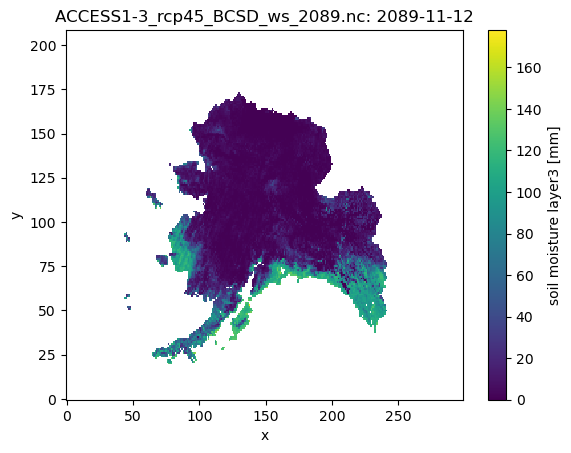

In [198]:
with xr.open_dataset(DATA_DIR / max_sm3) as ds:
    
    da = ds.SM3
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot()
    plt.title(f"{max_sm3}: {tstr}")

In [199]:
wf_evap_df = summary_stat_di["wf"].set_index("filename").query("variable == 'EVAP'")
wf_glacmelt_df = summary_stat_di["wf"].set_index("filename").query("variable == 'GLACIER_MELT'")
wf_runoff_df = summary_stat_di["wf"].set_index("filename").query("variable == 'RUNOFF'")
wf_snowmelt_df = summary_stat_di["wf"].set_index("filename").query("variable == 'SNOW_MELT'")

In [200]:
max_evap = wf_evap_df.sort_values("max_vals").index[-1]
max_glacmelt = wf_glacmelt_df.sort_values("max_vals").index[-1]
max_runoff = wf_runoff_df.sort_values("max_vals").index[-1]
max_snowmelt = wf_snowmelt_df.sort_values("max_vals").index[-1]

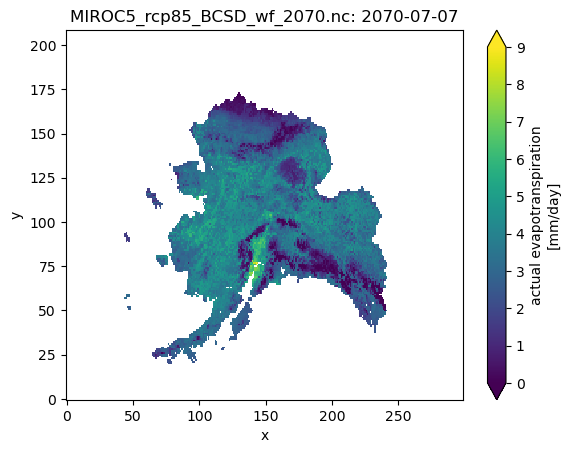

In [220]:
with xr.open_dataset(DATA_DIR / max_evap) as ds:
    
    da = ds.EVAP
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmin=0, vmax=9)
    plt.title(f"{max_evap}: {tstr}")

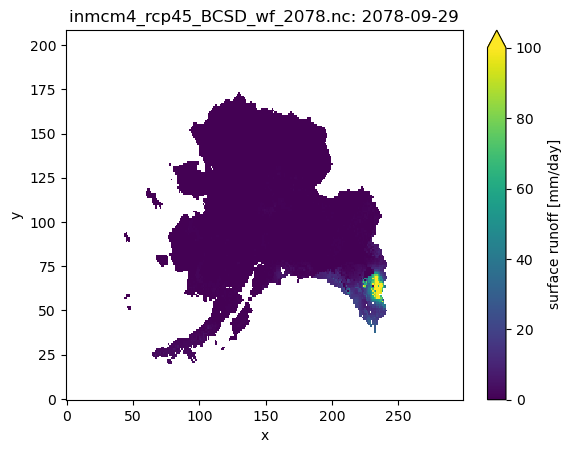

In [222]:
with xr.open_dataset(DATA_DIR / max_runoff) as ds:
    
    da = ds.RUNOFF
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=100)
    plt.title(f"{max_runoff}: {tstr}")

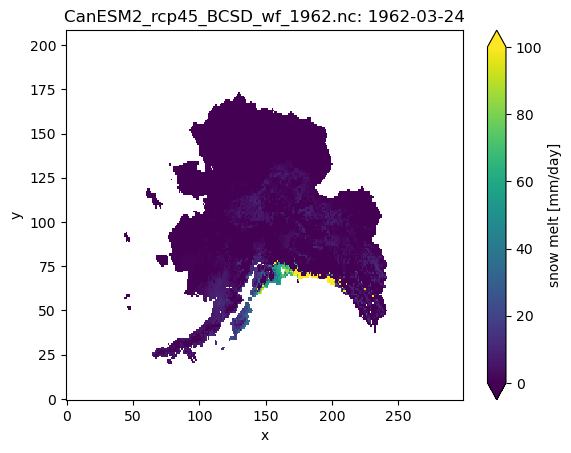

In [212]:
with xr.open_dataset(DATA_DIR / max_snowmelt) as ds:
    
    da = ds.SNOW_MELT
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmin=0, vmax=100)
    plt.title(f"{max_snowmelt}: {tstr}")

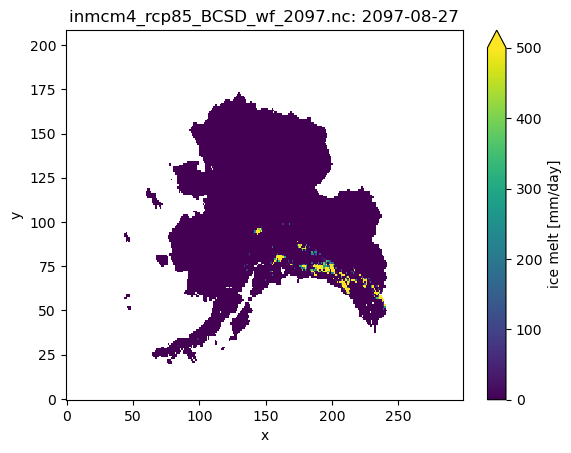

In [223]:
with xr.open_dataset(DATA_DIR / max_glacmelt) as ds:
    
    da = ds.GLACIER_MELT
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    # Extract the time coordinate of the maximum value
    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=500)
    plt.title(f"{max_glacmelt}: {tstr}")

In [1]:
# Plot 9 random slices for each variable

In [2]:
client.close()

NameError: name 'client' is not defined